In [7]:
from utils import *

# Friedman Data

## Dataset

In [8]:
X, y = make_friedman1()
datasets = processing(X, y)

X, y = datasets['orig']
X_norm, y_norm = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_train_norm, y_train_norm, y_train_norm_noisy = datasets['norm train']

## $\mathbb{R}^d$

In [9]:
ntk = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.05, 
        constant_value_bounds=(1e-9, 1e5) 
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed',#(1e-1, 1e3), 
    ) 
)

gp_ntk = GPR(kernel=ntk, alpha=1e-5, n_restarts_optimizer=9)
gp_ntk.fit(X_train, y_train)
print('NTK     : ', gp_ntk.kernel_)
mean_ntk = gp_ntk.predict(X)

gp_lpk = GPR(kernel=lpk, alpha=1e-5, n_restarts_optimizer=9)
gp_lpk.fit(X_train, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  1.65**2 * NTK(depth=3, c=2.000, bias=0.001)
Laplace :  6.12**2 * Matern(length_scale=1, nu=0.5)


(-10.0, 10.0)

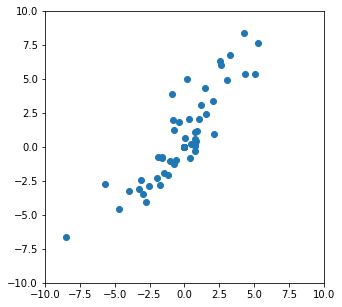

In [10]:
# NTK vs LPK residuals
plt.figure(figsize=(5,5))
plt.scatter(y - mean_ntk, y - mean_lpk)
plt.xlim(-10,10)
plt.ylim(-10,10)

## $\mathbb{S}^{d-1}$

In [11]:
gp_ntk = GPR(kernel=ntk, alpha=1e-5, n_restarts_optimizer=9)
gp_ntk.fit(X_train_norm, y_train_norm)
print('NTK     : ', gp_ntk.kernel_)
mean_ntk = gp_ntk.predict(X_norm)

gp_lpk = GPR(kernel=lpk, alpha=1e-5, n_restarts_optimizer=9)
gp_lpk.fit(X_train_norm, y_train_norm)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X_norm)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  3.54**2 * NTK(depth=3, c=2.000, bias=0.667)
Laplace :  6.9**2 * Matern(length_scale=1, nu=0.5)


(-10.0, 10.0)

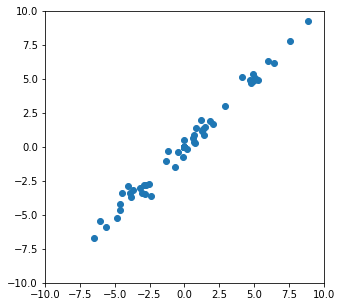

In [12]:
# NTK vs LPK residuals
plt.figure(figsize=(5,5))
plt.scatter(y - mean_ntk, y - mean_lpk)
plt.xlim(-10,10)
plt.ylim(-10,10)